Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re, shutil
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.regularizers import l2,l1,l1_l2
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
from glob import glob

In [2]:
# using Tensorflow version 2.8.0
tf.__version__

'2.15.0'

In [3]:
REMOVE_AUGMENTED_FILES = True
AUGMENTOR_IMAGES = 500

In [4]:

def clean_augmented_files(dir_in):
    for root, dirnames, filenames in os.walk(dir_in):
        root = re.sub(r'\\', "/", root)
        if 'output' in root:
            shutil.rmtree(root)
            if not os.path.exists(root):
                print(f"Removed: {root}")

In [6]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [30]:
if REMOVE_AUGMENTED_FILES:
    clean_augmented_files(IMAGES_PATH)

In [53]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
IMAGES_PATH='/content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset'
data_dir_train = pathlib.Path(IMAGES_PATH + '/Train')
data_dir_test = pathlib.Path(IMAGES_PATH + '/Test')
data_dir_test

PosixPath('/content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Test')

In [54]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [55]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [56]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# train_ds = ##todo
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [57]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
# val_ds = ##todo
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [58]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names, len(class_names))

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion'] 9


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

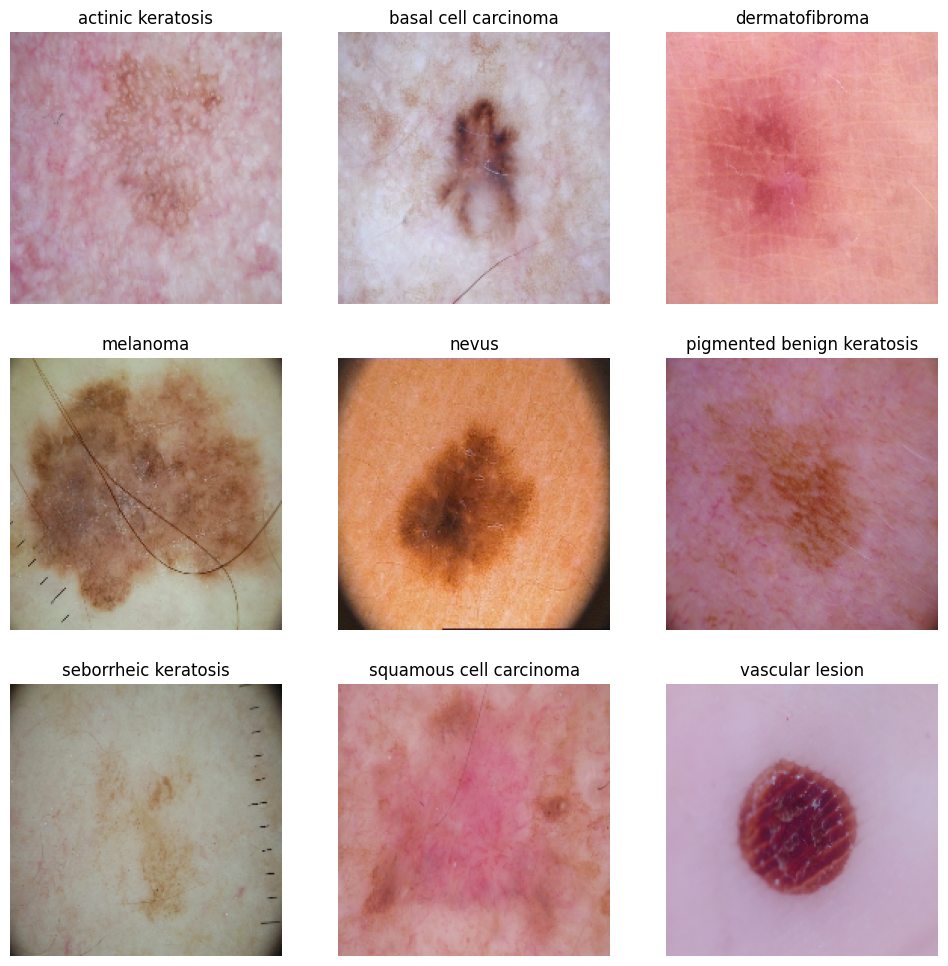

In [59]:
plt.figure(figsize=(12, 12))

j = 0
cnames_temp = class_names.copy()
for images, labels in val_ds:
    for i in range(len(images)):
#         print(j)
        if class_names[labels[i]] == class_names[j]:
            #arrange the images in a 3x3 grid of subplots
            ax = plt.subplot(3, 3, j + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
            j += 1
            if j == len(class_names):
                break
    if j == len(class_names):
                break


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [60]:
#inspect the shape of the batches of images and labels in the training dataset
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [61]:
#preparing the training and validation datasets for improved performance during training using TensorFlow's Dataset API
AUTOTUNE = tf.data.experimental.AUTOTUNE #this value is used to dynamically tune the number of elements processed in parallel
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)#Shuffling the data helps in preventing the model from learning the order of the examples and can lead to better generalization.
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
AUTOTUNE

-1

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [64]:
#defines a convolutional block for a neural network model using TensorFlow/Keras with LeakyReLU activation function
def add_conv_block(imodel,
    n_convs=1, n_filts=32, ikernel_size=(3, 3), istrides=1, ipadding="same",
    ialpha=0.05, ipool_size=(2, 2),
    pool_padding_same=False, bn=0, idropout=0.):

    for i in range(n_convs):
        imodel.add(layers.Conv2D(
            n_filts, kernel_size=ikernel_size, strides=istrides, kernel_initializer="he_normal", padding=ipadding))
        if bn:
            imodel.add(layers.BatchNormalization())
        imodel.add(tf.keras.layers.LeakyReLU(alpha=ialpha))

    if pool_padding_same:
        imodel.add(layers.MaxPooling2D(pool_size=ipool_size, strides=(1, 1), padding="same"))
    else:
        imodel.add(layers.MaxPooling2D(pool_size=ipool_size))
    if idropout > 0:
        imodel.add(layers.Dropout(idropout))


In [65]:
#defines a neural network model using the Sequential API of TensorFlow/Keras .it defines a neural network model with convolutional blocks followed by fully connected layers for image classification.
def get_my_model_1():
    num_classes = len(class_names)
    alpha = 0.2

    lmodel = Sequential()

    lmodel.add(layers.experimental.preprocessing.Rescaling(1./255., input_shape=(180, 180, 3)))

    add_conv_block(lmodel, 1, 64, ikernel_size=(9, 9), istrides=2, ipadding="same", bn=0)
    add_conv_block(lmodel, 1, 128, ikernel_size=(7, 7), bn=0)
    add_conv_block(lmodel, 2, 256, ikernel_size=(3, 3), bn=0)
    add_conv_block(lmodel, 2, 512, ikernel_size=(3, 3), pool_padding_same=False, bn=0)

    lmodel.add(layers.Flatten())

    lmodel.add(layers.Dense(2048, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))

    lmodel.add(layers.Dense(1024, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))

    lmodel.add(layers.Dense(num_classes, activation='softmax'))
    return lmodel

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [66]:
# this code sets up a learning rate schedule, initializes two different optimizers (Adam and SGD) with the same learning rate schedule, creates a neural network model, compiles the model with the Adam optimizer and appropriate loss function and metrics, and finally prints a summary of the model's architecture.
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=250,
    decay_rate=0.9)

adam = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9)

sgd = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule, momentum=0.99, nesterov=True
)

model1 = get_my_model_1()
model1.compile(optimizer=adam,
              loss= tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 90, 90, 64)        15616     
                                                                 
 leaky_re_lu_32 (LeakyReLU)  (None, 90, 90, 64)        0         
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 45, 45, 128)       401536    
                                                                 
 leaky_re_lu_33 (LeakyReLU)  (None, 45, 45, 128)       0         
                                                      

Here's a summary of the layers in the model:

Rescaling layer: It rescales the input pixel values to the range [0, 1].
Convolutional layers with LeakyReLU activation and max-pooling:
Three convolutional blocks with varying numbers of convolutional layers (1-2 layers) and filter sizes (64-512).
Each convolutional block is followed by a LeakyReLU activation.
The max-pooling layers reduce the spatial dimensions of the feature maps.
Flatten layer: It flattens the output of the convolutional layers into a 1D tensor.
Dense layers with LeakyReLU activation:
Two dense layers with 2048 and 1024 neurons, respectively.
Each dense layer is followed by a LeakyReLU activation.
Output layer: It is a dense layer with 9 neurons (assuming there are 9 classes in the classification problem) and softmax activation function.
The model has a total of 33,166,217 parameters, all of which are trainable.

### Train the model

In [67]:
#trains the model1 neural network model on the provided training dataset for 20 epochs while monitoring its performance on the validation dataset after each epoch.
epochs = 20
history = model1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
#     multi_processing=True
)


Epoch 1/20
56/56 [==============================] - 23s 127ms/step - loss: 2.3791 - accuracy: 0.2489 - val_loss: 1.7239 - val_accuracy: 0.3669
Epoch 2/20
56/56 [==============================] - 4s 66ms/step - loss: 1.6318 - accuracy: 0.3956 - val_loss: 1.6419 - val_accuracy: 0.4273
Epoch 3/20
56/56 [==============================] - 4s 66ms/step - loss: 1.5304 - accuracy: 0.4682 - val_loss: 1.4831 - val_accuracy: 0.5257
Epoch 4/20
56/56 [==============================] - 4s 67ms/step - loss: 1.4037 - accuracy: 0.5156 - val_loss: 1.4111 - val_accuracy: 0.5123
Epoch 5/20
56/56 [==============================] - 4s 67ms/step - loss: 1.3543 - accuracy: 0.5251 - val_loss: 1.4022 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 4s 66ms/step - loss: 1.2671 - accuracy: 0.5519 - val_loss: 1.3528 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 4s 67ms/step - loss: 1.2061 - accuracy: 0.5709 - val_loss: 1.2970 - val_accuracy: 0.5436
Epoch 8/20


In [68]:
##after training for 20 epochs, the model achieved an accuracy of approximately 87.83% on the training dataset and 57.05% on the validation dataset.

### Visualizing training results

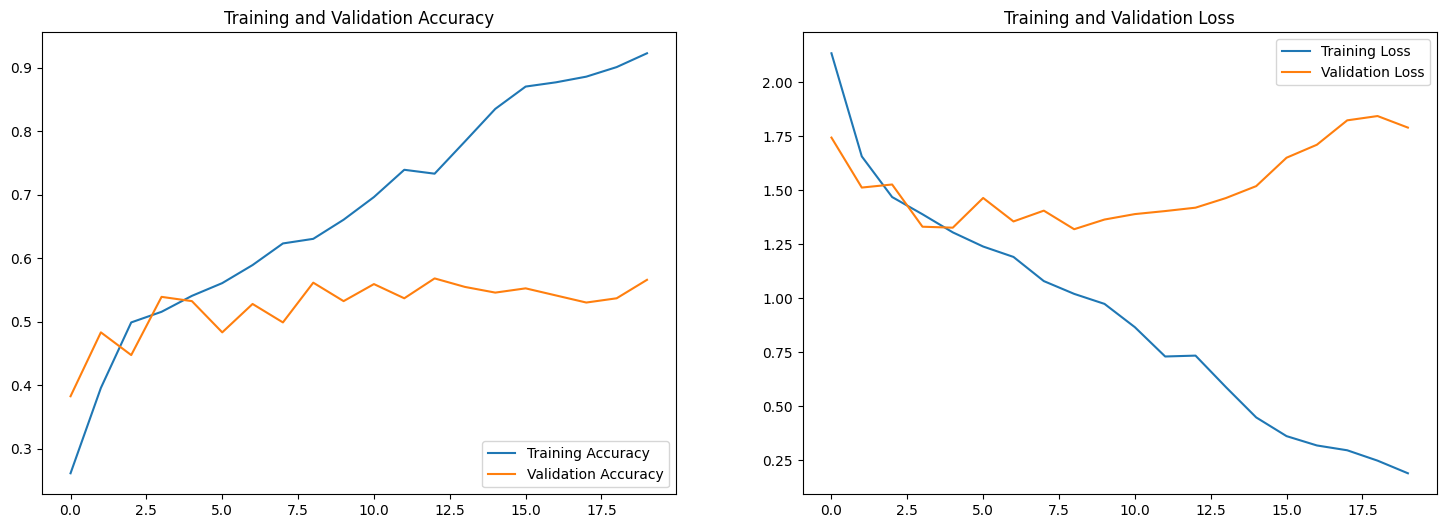

In [51]:
#visualize the training and validation accuracy as well as the training and validation loss over the epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**: Model seems to be Overfitting

*   Train accuracy increases continuously.Validation accuracy increases in the beginning and then it remains constant.  
*   training accuracy and loss continue to improve while the validation accuracy and loss start to deteriorate


Based on above findings, we can say that the model is overfitting.
Model need regularization techniques or adjustments to prevent overfitting and improve generalization performance.
- More data might help
- More number of epochs will also help
- Handling class imbalance might help

### Data augmentation - Keras built-in (lets due the agumentation to reduce the overfitting)

In [70]:
# set up a data augmentation pipeline using TensorFlow/Keras preprocessing layers. augmentation will be a Sequential model containing the data augmentation layers in the specified order. We can then use this model as a preprocessing step before feeding the images into your neural network model during training.
# Data augmentation is a technique used to artificially increase the size of a training dataset by applying various transformations to the existing data. This helps improve the generalization ability of the model and reduces overfitting.

augmentation_layers = [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", seed=123),
    layers.experimental.preprocessing.RandomZoom(.25, .25, seed=123),
    layers.experimental.preprocessing.RandomRotation(0.25, seed=123)
]

data_augmentation = tf.keras.Sequential()
data_augmentation.add(layers.experimental.preprocessing.Rescaling(1./255., input_shape=(180, 180, 3)))
for al in augmentation_layers:
    data_augmentation.add(al)

#### Visualize data augmentation for a single instance

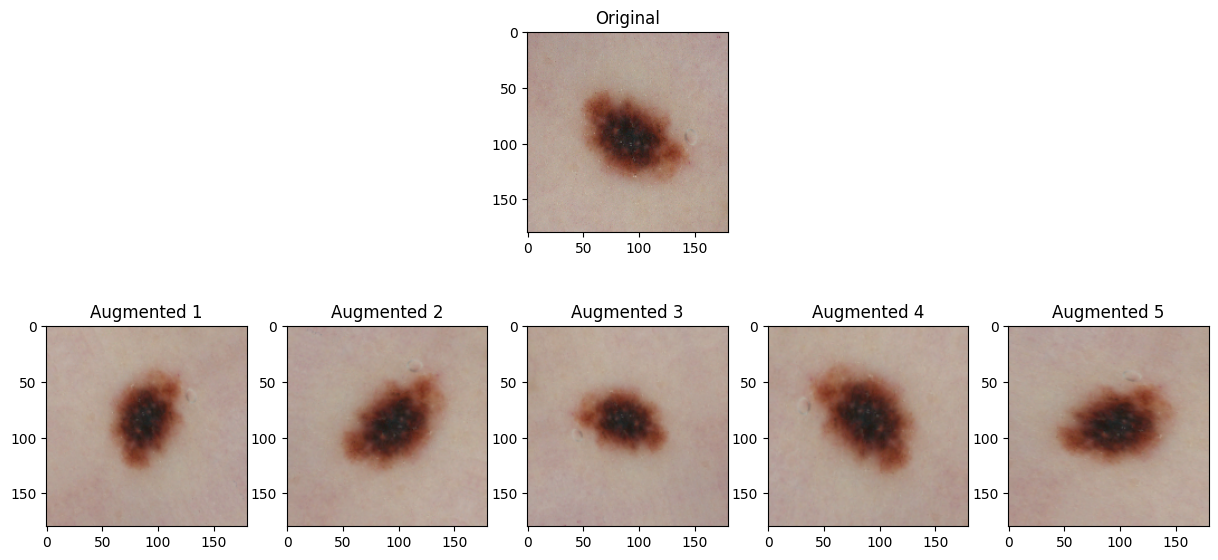

In [71]:
#generates and displays 5 augmented versions of the original image, showcasing how data augmentation techniques such as random flip, zoom, and rotation can introduce variations to the training data to improve the robustness and generalization ability of the model.
melanoma = list(data_dir_train.glob('melanoma/*'))
img = load_img(str(melanoma[0]), target_size=(180, 180, 3))
xi = img_to_array(img)
image = xi.reshape((1,) + xi.shape)
# image = tf.cast(tf.expand_dims(img, 0), tf.float32)

plt.figure(figsize=(15, 7))
ax2 = plt.subplot(2, 5, 3)
plt.title("Original")
plt.imshow(img)
for i in range(5):
#     print(i)
    augmented_image = data_augmentation(image, training=True)
    ax1 = plt.subplot(2, 5, 5 + i + 1)
    plt.title(f"Augmented {i+1}")
    plt.imshow(augmented_image[0])
#   plt.axis("off")
plt.show()

### Create the model, compile and train the model

In [72]:
#create model with an additional preprocessing step that includes the data augmentation layers.
def get_my_model_2():
    num_classes = len(class_names)
    alpha = 0.3

    lmodel = Sequential()

    lmodel.add(layers.experimental.preprocessing.Rescaling(1./255., input_shape=(180, 180, 3)))

    for augmentation_layer in augmentation_layers:
        lmodel.add(augmentation_layer)

    add_conv_block(lmodel, 1, 64, ikernel_size=(9, 9), istrides=2, ipadding="same", bn=0)
    add_conv_block(lmodel, 1, 128, ikernel_size=(7, 7), bn=0)
    add_conv_block(lmodel, 2, 256, ikernel_size=(3, 3), bn=0)
    add_conv_block(lmodel, 2, 512, ikernel_size=(3, 3), pool_padding_same=False, bn=0)

    lmodel.add(layers.Flatten())

    lmodel.add(layers.Dense(2048, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))

    lmodel.add(layers.Dense(1024, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))

    lmodel.add(layers.Dense(num_classes, activation='softmax'))
    return lmodel


### Compiling the model

In [52]:
### Set up a learning rate schedule for two different optimizers (Adam and SGD), creates a neural network model using the get_my_model_2() function (which includes data augmentation layers), compiles the model with specified optimizer, loss function, and metrics, and then prints a summary of the model's architecture.

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=250,
    decay_rate=0.9)

adam = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9)

sgd = tf.keras.optimizers.SGD(
    learning_rate=lr_schedule, momentum=0.99, nesterov=True
)

model2 = get_my_model_2()
model2.compile(optimizer=adam,
              loss= tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 180, 180, 3)       0         
 ation)                                                          
                                                                 
 conv2d_18 (Conv2D)          (None, 90, 90, 64)        15616     
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 90, 90, 64)        0         
                                                      

### Training the model

In [73]:
## trains the model2 neural network model on the provided training dataset for 20 epochs while monitoring its performance on the validation dataset after each epoch.
epochs = 20
history2 = model2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
)

Epoch 1/20
56/56 [==============================] - 8s 73ms/step - loss: 2.3246 - accuracy: 0.2550 - val_loss: 1.6872 - val_accuracy: 0.4094
Epoch 2/20
56/56 [==============================] - 4s 69ms/step - loss: 1.6874 - accuracy: 0.3884 - val_loss: 1.7555 - val_accuracy: 0.3781
Epoch 3/20
56/56 [==============================] - 4s 71ms/step - loss: 1.5270 - accuracy: 0.4637 - val_loss: 1.4660 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4480 - accuracy: 0.4754 - val_loss: 1.4518 - val_accuracy: 0.5078
Epoch 5/20
56/56 [==============================] - 4s 70ms/step - loss: 1.4000 - accuracy: 0.5095 - val_loss: 1.4489 - val_accuracy: 0.4698
Epoch 6/20
56/56 [==============================] - 4s 72ms/step - loss: 1.3557 - accuracy: 0.5145 - val_loss: 1.4048 - val_accuracy: 0.5190
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.3010 - accuracy: 0.5419 - val_loss: 1.3592 - val_accuracy: 0.5436
Epoch 8/20
56

### Visualizing the results

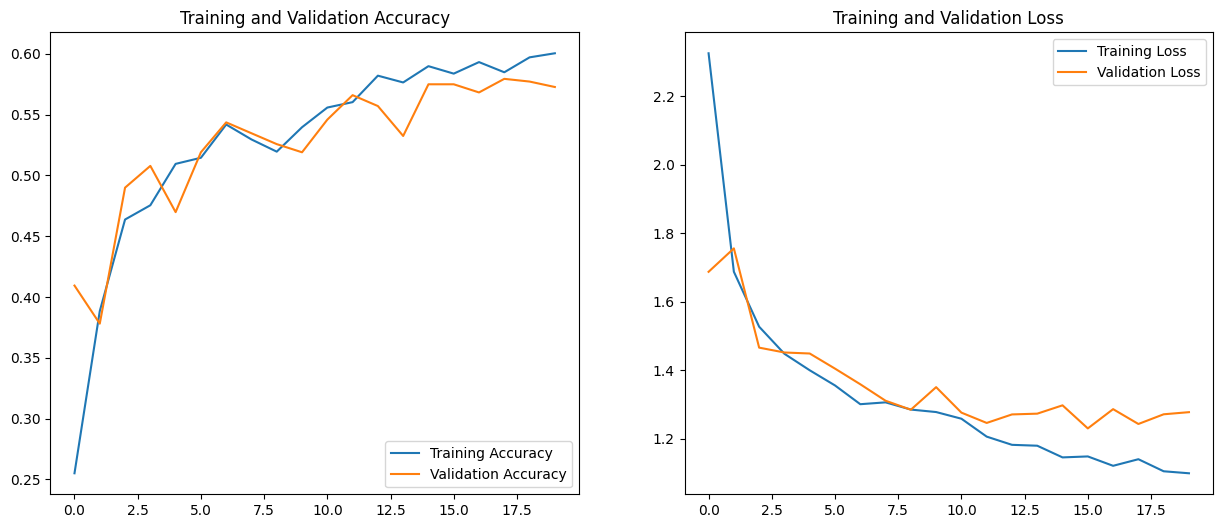

In [74]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

- The training loss (loss) decreased from 0.3090 to 1.0995, which might indicate that the model is fitting the training data less accurately.
- The training accuracy (accuracy) decreased from 87.83% to 60.04%, indicating that the model's performance on the training dataset has decreased significantly.
- The validation loss (val_loss) increased from 1.6384 to 1.2778, suggesting that the model's performance on unseen data has deteriorated.
- The validation accuracy (val_accuracy) slightly increased from 57.05% to 57.27%, but this change is relatively small

Overall, these results suggest that the model might be overfitting to the training data, as indicated by the decrease in training accuracy and increase in validation loss compared to the earlier results. Further analysis and possibly adjustments to the model architecture or training process may be necessary to improve its performance.training for more epochs might help

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

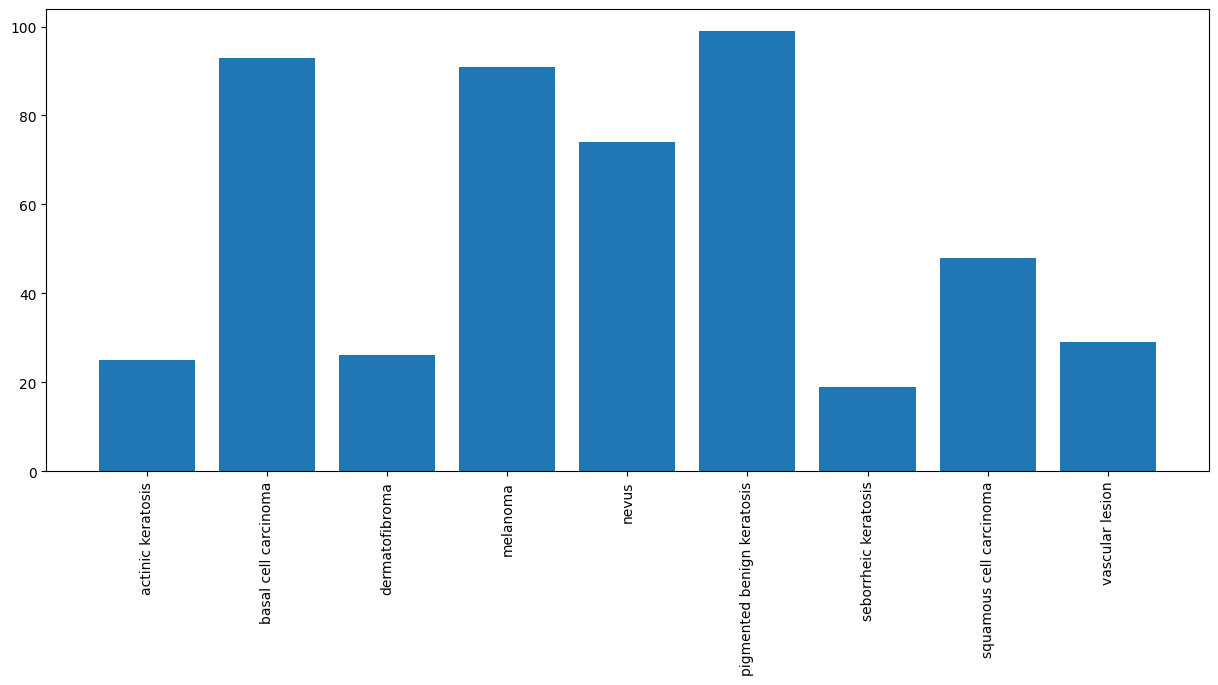

In [75]:
## his code calculates the number of images for each class in the training dataset and visualizes this distribution using a bar plot. Each bar represents a class, and the height of the bar indicates the number of images available for that class in the training dataset.
#This visualization helps to understand the class distribution and potential class imbalances in the dataset.

data = dict()

for i in class_names:
  data[i] = []

# plt.figure(figsize=(10, 6))
for images, labels in train_ds:
  for i in range(9):
    data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
  data[i] = len(data[i])

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(6)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()), rotation=90)
plt.show()

#### Findings
- seborrheic keratosis has the least numbers of samples
- pigmented benign keratosis, melanoma and basal cell carcinoma have most samples. These classes dominate the data in terms proportionate number of samples

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [76]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [77]:
import Augmentor
Augmentor.__version__

'0.2.12'

In [78]:
# sets up a data augmentation pipeline using Augmentor to augment images in the training dataset directory for each class.
#The augmentation operations are applied to create additional samples per class, ensuring that none of the classes are sparse in the dataset.
path_to_training_dataset = f"{IMAGES_PATH}/Train"
import Augmentor

if REMOVE_AUGMENTED_FILES:
    clean_augmented_files(path_to_training_dataset)

for i in class_names:
    print(i, path_to_training_dataset + '/' + i)
    p = Augmentor.Pipeline(path_to_training_dataset + '/' + i)
    p.rotate(probability=0.5, max_left_rotation=25, max_right_rotation=25)
    p.zoom(probability=0.5, min_factor=1.0, max_factor=1.6)
    p.flip_left_right(probability=0.3)
    p.resize(probability=1., width=180, height=180)
    p.sample(AUGMENTOR_IMAGES) ## We are adding samples per class to make sure that none of the classes are sparse.

actinic keratosis /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7AE7301C9510>: 100%|██████████| 500/500 [00:18<00:00, 26.51 Samples/s]


basal cell carcinoma /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7AE725E274F0>: 100%|██████████| 500/500 [00:20<00:00, 24.69 Samples/s]


dermatofibroma /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7AE725C1D660>: 100%|██████████| 500/500 [00:21<00:00, 23.64 Samples/s]


melanoma /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/melanoma
Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7AE7301C9300>: 100%|██████████| 500/500 [01:44<00:00,  4.80 Samples/s]


nevus /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/nevus
Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7AE79008E4D0>: 100%|██████████| 500/500 [01:15<00:00,  6.66 Samples/s]


pigmented benign keratosis /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7AE7A416DD50>: 100%|██████████| 500/500 [00:19<00:00, 25.65 Samples/s]


seborrheic keratosis /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7AE7900AF3D0>: 100%|██████████| 500/500 [00:41<00:00, 12.06 Samples/s]


squamous cell carcinoma /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7AE7A4140430>: 100%|██████████| 500/500 [00:19<00:00, 26.12 Samples/s]


vascular lesion /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/upgrad_app/CNN_skin_dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=180x180 at 0x7AE7901FC490>: 100%|██████████| 500/500 [00:21<00:00, 23.29 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [79]:
data_dir_train_aug = pathlib.Path(f"{IMAGES_PATH}/Train")
image_count_train = len(list(data_dir_train_aug.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [80]:
#collects information about the paths of original and augmented images, as well as the corresponding lesion labels for both sets of images, likely for further analysis or validation purposes.
path_list = [x for x in glob(os.path.join(data_dir_train_aug, '*','output', '*.jpg'))]
print(len(path_list))
path_list_orig = [x for x in glob(os.path.join(data_dir_train_aug, '*', '*.jpg'))]
print(len(path_list_orig))
lesion_list_orig = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train_aug, '*', '*.jpg'))]
print(len(lesion_list_orig))
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train_aug, '*','output', '*.jpg'))]
lesion_list_new[0:5]

4500
2239
2239


['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis']

In [81]:
# these dictionaries provide a mapping between image paths and their corresponding lesion labels, both for the augmented images (dataframe_dict_new) and the original images (dataframe_dict_orig).
dataframe_dict_new = dict(zip(path_list, lesion_list_new))
dataframe_dict_orig = dict(zip(path_list_orig, lesion_list_orig))

In [82]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(list(dataframe_dict_orig.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])# original_df.append(df2)
new_df.shape
#new_df is a DataFrame that contains information about both original and augmented images, including their paths and corresponding lesion labels

(6739, 2)

In [83]:
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [84]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [85]:
# data_dir_train_aug=pathlib.Path(path_to_training_dataset)
train_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.1,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 6066 files for training.


#### **Todo:** Create a validation dataset

In [86]:
val_ds_aug = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train_aug,
  seed=123,
  validation_split = 0.1,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 673 files for validation.


In [87]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds_aug = train_ds_aug.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_aug = val_ds_aug.cache().prefetch(buffer_size=AUTOTUNE)
AUTOTUNE

-1

#### **Todo:** Create your model (make sure to include normalization)

In [88]:
def get_my_model_3():
    num_classes = len(class_names)
    alpha = 0.2

    lmodel = Sequential()
    #normalizing the Data
    lmodel.add(layers.experimental.preprocessing.Rescaling(1./255., input_shape=(180, 180, 3)))

    add_conv_block(lmodel, 1, 64, ikernel_size=(9, 9), istrides=2, ipadding="same")
    add_conv_block(lmodel, 1, 128, ikernel_size=(7, 7), idropout=0.2)
    add_conv_block(lmodel, 2, 256, ikernel_size=(3, 3), idropout=0.2)
    add_conv_block(lmodel, 2, 512, ikernel_size=(3, 3), pool_padding_same=False, idropout=0.2)

    lmodel.add(layers.Flatten())
    lmodel.add(layers.Dropout(0.3))

    lmodel.add(layers.Dense(2048, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))
    lmodel.add(layers.Dropout(0.3))

    lmodel.add(layers.Dense(1024, kernel_initializer="he_normal"))
    lmodel.add(tf.keras.layers.LeakyReLU(alpha=alpha))
    lmodel.add(layers.Dropout(0.3))

    lmodel.add(layers.Dense(num_classes, activation='softmax'))
    return lmodel

model3 = get_my_model_3()

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [89]:

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=200,
    decay_rate=0.95)

adam = keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9)

model3 = get_my_model_3()
model3.compile(optimizer=adam,
              loss= tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_9 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_36 (Conv2D)          (None, 90, 90, 64)        15616     
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 90, 90, 64)        0         
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 45, 45, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (None, 45, 45, 128)       401536    
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 45, 45, 128)       0         
                                                      

#### **Todo:**  Train your model

In [90]:

epochs = 30
history_aug = model3.fit(
    train_ds_aug,
    validation_data=val_ds_aug,
    epochs=epochs
)

Epoch 1/30
190/190 [==============================] - 51s 102ms/step - loss: 2.3069 - accuracy: 0.2029 - val_loss: 1.8692 - val_accuracy: 0.3165
Epoch 2/30
190/190 [==============================] - 13s 71ms/step - loss: 1.6738 - accuracy: 0.3549 - val_loss: 1.5297 - val_accuracy: 0.4146
Epoch 3/30
190/190 [==============================] - 14s 71ms/step - loss: 1.5288 - accuracy: 0.4125 - val_loss: 1.4649 - val_accuracy: 0.4562
Epoch 4/30
190/190 [==============================] - 14s 71ms/step - loss: 1.4625 - accuracy: 0.4408 - val_loss: 1.4665 - val_accuracy: 0.4502
Epoch 5/30
190/190 [==============================] - 13s 71ms/step - loss: 1.3834 - accuracy: 0.4687 - val_loss: 1.3896 - val_accuracy: 0.4621
Epoch 6/30
190/190 [==============================] - 13s 70ms/step - loss: 1.3454 - accuracy: 0.4899 - val_loss: 1.3236 - val_accuracy: 0.4859
Epoch 7/30
190/190 [==============================] - 13s 70ms/step - loss: 1.2908 - accuracy: 0.5099 - val_loss: 1.3731 - val_accuracy

#### **Todo:**  Visualize the model results

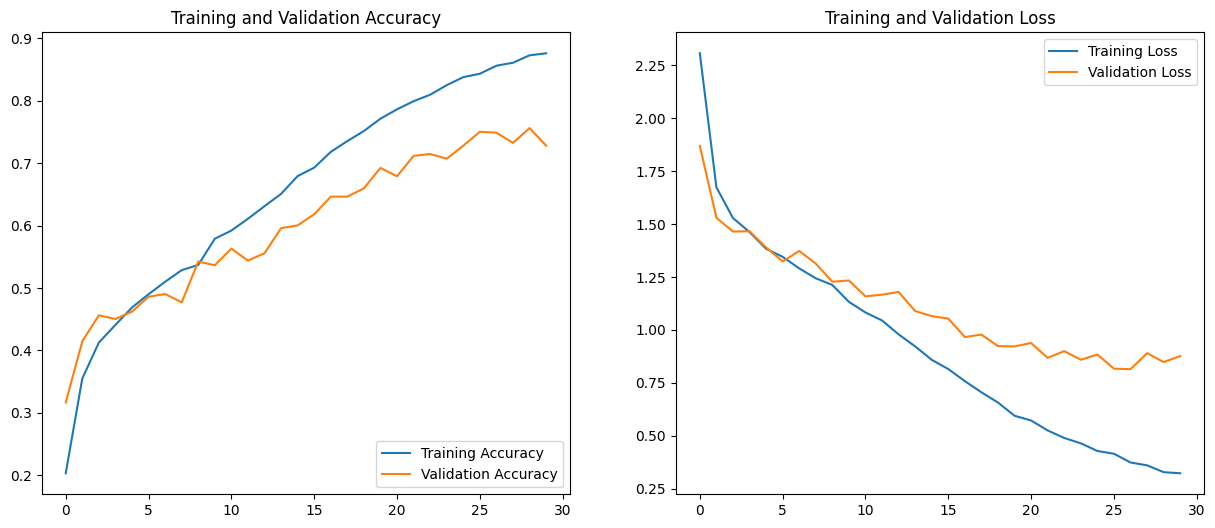

In [91]:
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

- Model 3 was trained for 30 epochs (500 images)
- Augmentor was used to reduce class imbalance
- Observations:

    - Final model is still overfitting slightly
    - Validation accuracy is much better than model 1 and model .The validation accuracy (val_accuracy) increased from approximately 57.05% to 72.81%, indicating a significant improvement in the model's ability to generalize to new, unseen data.
    - The validation loss (val_loss) decreased from approximately 1.6384 to 0.8767, suggesting an improvement in the model's performance on unseen data.
    - Rebalancing classes by increasing number of images helped in increasing accuracy and reducing overfitting
    - Increasing number of epochs also helped

#### Class rebalance increases validation accuracy to 72.81%. training accuracy is 87.62%
#### Increasing images and epochs further will help reduce overfitting